# Loss Functions Part 1

> "In this part of the multi-part series on Loss Functions we'll look at the concepts like Information Entropy, Cross Entropy, KL-Divergence, how they are linked to each other and how to code them in Python"

- toc: true
- branch: fastbook/lessons
- badges: true
- comments: true
- image: images/entropy.png
- categories: [loss_functions]
- hide: false
- author: Akash Mehra

## Introduction

A Loss/Cost function or an objective function in Machine Learning (ML) is a function that maps the values of one or more variables to a scalar value. This scalar value is then used to minimize the loss/cost incurred while making a prediction. On a very high level, an ML algorithm works as follows:

![](nb_images/loss_functions/wf.png)

The diagram above is a very high-level overview of a model learning from data. We've simplified the training workflow a lot in the above diagram, we also have a step where the gradient of the loss wrt the model parameters gets calculated (we'll talk about autodiff in a detailed post later on) and then the optimizer uses those acumulated gradients for each parameter and updates the parameters for next iteration.

The choice of a loss function plays an important role in learning from data. It depends on what we want to learn, and what we want to predict. In some cases we just want to predict the distribution of the categories (discrete values), there we end up using a certain type of loss function while in some other cases we'd like to predict continuous values and there the choice of loss function would be completely different. Some time we'd like to perform metric learning, and the loss function for such a problem would not fall in the aforementioned categories. Below we review some of the loss functions that are most commonly used for some of the common problems in the field of ML.

## Types of Loss Functions

### Classification

#### Cross Entropy Loss

##### Entropy

There's something to be said about Entropy before we look into Cross-Entropy. Entropy, is such a beautiful concept that I got first introduced to in an information theory course I took years ago. The whole process can be seen as how many bits we need to encode the message on the transmitter side to be able to successfully decode at the receiver. The concept was introduced by Claude Shannon and it is also known as Shannon entropy.

![](nb_images/loss_functions/shannon_info_system.png)

<figure>
    <figcaption align="center">Source: 
        <a link="https://web.archive.org/web/20120615000000*/https://www.alcatel-lucent.com/bstj/vol27-1948/articles/bstj27-3-379.pdf">A Mathematical Theory of Communication</a> 	 
    </figcaption>
</figure>



Formally, given a discrete random variable $X$, with possible outcomes $x_1,x_2,...,x_n$, which occur with probability $P(x_1),P(x_2),...,P(x_n)$ the entropy of $X$​ is given by:
$$
\boxed{H(X) = - \sum_{i=1}^{n} P(x_i) \log(P(x_i))}
$$
What follows next is the characterization and can be found here on [Wikipedia](https://en.wikipedia.org/wiki/Entropy_(information_theory))

> To understand the meaning of the above equation, first define an information function $I$ in terms of an event $x_i$ with probability $P(x_i)$. The amount of information acquired due to the observation of event $x_i$ follows from Shannon's solution of the fundamental properties of information.


 1. $I(p)$ is monotonically decreasing in $p$, an increase in the probability $p$  of an event decreases the information observed.
 2. $I(p) \geq 0$, information is a non-negative quantity
 3. $I(1) = 0$, events that always occur, don't convey any information
 4. $I(p_1, p_2)$ = $I(p_1) + I(p_2)$ if $p_1$ and $p_2$ are independent.

*Shannon* discovered that the suitable choice for $I$ is given by $I(p) = \log(p)$​. 

Using above to analyze the equation of $H(X)$​​​​​​​, we see that the number of bits required to encode a message when $P(x_i) = 1$​​​​​​ or $P(x_i) = 0$​​​​​​ is $0$​​​​​​, this is due to the fact that we're either sure that the event will happen or it won't (we'll not communicate). An increase in the value of $P(x_i)$​​​​​ decreases the value of the measure (*Entropy*). 

Below is the plot of *Information* vs *Probability* or $I(p)$​​ vs $p$ which tells us that *Information*​ conveyed by the event decreases as *Probability* increases

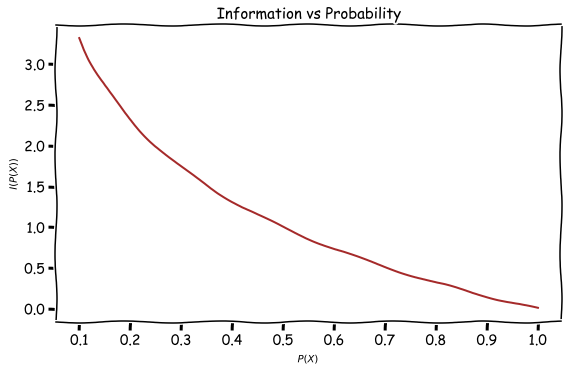

In [429]:
#collapse-hide
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
precision = 4
np.set_printoptions(precision=precision)
pd.set_option("precision", precision)
import torch
from torch.nn import functional as F

class InformationMeasure():
    @staticmethod
    def entropy(prob):
        return np.sum(-prob * np.log2(prob, out=np.zeros_like(prob), where=(prob!=0)))
      
class Plotter():
    @staticmethod
    def plot_xy(x,y, x_label, y_label, title, show_grid=True, legend=True, 
                legend_loc='upper right', x_ticks=np.arange(0.0, 1.1, 0.5), plot_point=False, show_axes=True):
        with plt.xkcd():
            #plt.style.use('ggplot')
            fig, ax = plt.subplots(figsize=(8, 5))
            fig.tight_layout()
            ax.plot(x,y, linewidth=2.0, color='brown')
            if plot_point:
                ax.plot(0.5, 1.0, 'go', label='P(X = 1) = 0.5')
            ax.set_xlabel(x_label, fontsize=10,  color='black')
            ax.set_ylabel(y_label, fontsize=10,  color='black')
            ax.set_title(title, fontsize=15, color='black')
            ax.grid(False)
            if not show_axes:
                plt.axis('off')
            if legend:
                ax.legend(loc=legend_loc)
            x_ticks = ax.set_xticks(x_ticks)
            return fig, ax
class CoinToss():
    def __init__(self):
        self.x = np.arange(0.0, 1.0, 0.01)
        self.x = np.append(self.x, 1.0)
        self.hx = np.asarray([np.asarray(InformationMeasure.entropy(np.asarray(prob))) for \
                               prob in zip(self.x, 1-self.x)], dtype=np.float64)
    def plot(self):
        return Plotter.plot_xy(self.x, self.hx, x_label='P(X = 1)', 
                               y_label='H(X)', title='Entropy of a coin flip', 
                               plot_point=True)
class EntropyFunction():
    def __init__(self):
        self.x = np.arange(0.1, 1.0, 0.01)
        self.x = np.append(self.x, 1.0)
        self.hx = -np.log2(self.x, out=np.zeros_like(self.x), where=(self.x!=0))
    def plot(self):
        return Plotter.plot_xy(self.x, self.hx, x_label='$P(X)$', 
                               y_label='$I(P(X))$', 
                               title='Information vs Probability', 
                               legend=False, x_ticks=np.arange(0.1, 1.1, 0.1))
entropy_func = EntropyFunction()
fig, ax = entropy_func.plot()

Now, let's consider as an example, tossing a biased coin whose probability of landing on heads is $p$​ and the probability of landing on tails is $1-p$​​, this can be modelled as a *Bernoulli Process*. Below is the *Entropy* vs *Probability* plot for the process:

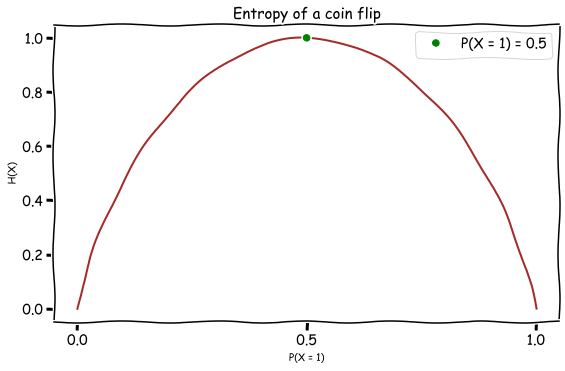

In [397]:
#collapse-hide
fig, ax = CoinToss().plot()	


##### Cross-Entropy

Building upon the concept of *Entropy* we come across *Cross-Entropy* which tells us the average number of bits required to encode the information coming from a source distribution $P$ using a model distribution $Q$. 
$$
H(P, Q) = - \sum_{i=1}^{n} P(x_i) \log (Q(x_i))
$$
Here, we generally don't have access to the target distribution $P$​​, so we approximate it by the model distribution $Q$​​, and the closer $Q$​ is to $P$​ the lesser the average number of bits required to encode the information. One could also write $H(P,Q)$ in terms of expectation as follows:
$$
H(P, Q) = - \mathbb{E}_{P(x)}[\log(Q(x))]
$$

##### KL-Divergence

KL-Divergence (also known as **relative entropy**) is a type of *f-divergence*, which is a measure of how one probability distribution is different from the other. In Information theory terms, it's the extra numher of bits required to encode the information from source distribution $P$​​​​ when using the model distribution $Q$​​​. The divergence of $Q$​​ from $P$​ is defined as:
$$
\mathbb{D}_{KL}(P || Q) = \sum_{i=1}^{n} P(x_i) \log (\frac {Q(x_i)}{P(x_i)})
$$

##### Putting it all together

One can see that there exists a relationship between $\mathbb{D}_{KL}(P || Q)$​ and $H(P,Q)$. Let's see if we can write one in terms of the other. 
$$
\mathbb{D}_{KL}(P || Q) = \sum_{i=1}^{n} P(x_i) \log (\frac {Q(x_i)}{P(x_i)}) \implies -\mathbb{E}_{P(x)}\left [log\left(\frac{Q(x)}{P(x)}\right)\right] \implies -\mathbb{E}_{P(x)}[\log(Q(x))] + \mathbb{E}_{P(x)}[\log(P(x))]
$$

$$
\mathbb{D}_{KL}(P || Q) = -\mathbb{E}_{P(x)}[\log(Q(x))] + \mathbb{E}_{P(x)}[\log(P(x))]
$$

$$
\mathbb{D}_{KL}(P || Q) = H(P,Q) - H(P) \implies H(P,Q) = H(P) + \mathbb{D}_{KL}(P || Q)
$$

##### Calculating Cross Entropy and KL Divergence

The code for calculating *Cross Entropy* and *KL Divergence* is just the direct translation of the equations above.

In what follows next, we're assuming that the input to these functions are probability distributions.

In [398]:
def cross_entropy(p, q):
    # both p and q are asuumed be probability distributions.
    return np.sum(-p * np.log(q))

A way to turn scores into probability distribution is via *Softmax* function, which is defined as follows:

In [399]:
def softmax(p):
    return np.exp(p)/np.sum(np.exp(p), axis=-1, keepdims=True)

Notice how we're using the `axis` parameter to only take the sum along the last dimension in case we're dealing with more than one dimensions (which usually is the case).

Next, we'll create sample probability distributions for demonstration purposes.

In [400]:
def get_sample_dist(rs, size=(10,)):
    # Return a sample (or samples) from the "standard normal" distribution.
    scores = rs.randn(*size)
    # covert to a probability distribution
    p = softmax(scores)
    return scores, p

In [401]:
#collapse-hide
def sanity_check_dist(p):
    if p.ndim > 1:
        expected = np.ones(p.shape[-2])
    else:
        expected = 1.0
    return np.allclose(np.sum(p, axis=-1), expected)

In [402]:
#collapse-hide
def print_as_table(p):
    return pd.DataFrame(data=p, index=[f"{i}" for i in range(p.shape[0])], columns=[f"{i}" for i in range(p.shape[1])])

We'll now out to test what we've coded so far

In [403]:
#hide-output
seed = 42
rs = np.random.RandomState(seed)
scores_p, p = get_sample_dist(rs, (10,5))
scores_q, q = get_sample_dist(rs, (10,5))

sanity_check_dist(p), sanity_check_dist(q)

(True, True)

Here's how $p^*$ looks like:

$^*$For demonstration purposes, I've chosen the distributions to be 2 dimensional so that it can be visually inspected.

In [404]:
#collapse-hide
print_as_table(p)

,0,1,2,3,4
0,0.1676,0.0888,0.1950,0.4678,0.0807
1,0.0780,0.4783,0.2124,0.0617,0.1696
2,0.2203,0.2197,0.4459,0.0517,0.0624
3,0.1932,0.1231,0.4643,0.1368,0.0826
4,0.6170,0.1137,0.1524,0.0343,0.0827
5,0.2670,0.0756,0.3479,0.1311,0.1785
6,0.0520,0.6052,0.0937,0.0330,0.2161
7,0.0936,0.3911,0.0447,0.0841,0.3864
8,0.4073,0.2310,0.1734,0.1440,0.0444
9,0.0873,0.1131,0.5160,0.2528,0.0308


Here's how $q$ looks like:

In [405]:
#collapse-hide
print_as_table(q)

,0,1,2,3,4
0,0.1916,0.0943,0.0704,0.2554,0.3884
1,0.3275,0.0558,0.0947,0.1797,0.3423
2,0.1428,0.1915,0.0763,0.0697,0.5197
3,0.4086,0.0979,0.2871,0.1511,0.0552
4,0.1205,0.3909,0.0810,0.4014,0.0061
5,0.4260,0.2043,0.1389,0.2052,0.0257
6,0.1048,0.1867,0.5725,0.0778,0.0582
7,0.0897,0.3699,0.2058,0.0872,0.2474
8,0.1958,0.4681,0.0881,0.1280,0.1200
9,0.0496,0.2879,0.2780,0.2152,0.1693


In [415]:
print(f'Cross Entropy between P and Q: {cross_entropy(p,q): .4f}')
print(f'Cross Entropy between P and P: {cross_entropy(p,p): .4f}')
print(f'Entropy of P: {entropy(p): .4f}')

Cross Entropy between P and Q:  18.2452
Cross Entropy between P and P:  13.2577
Entropy of P:  13.2577


The code snippet calculates *cross entropy*, to calculate *kl divergence* we'll introduce another function

In [416]:
def kl_div(p, q):
    return np.sum(-p * (np.log(q) - np.log(p)))
print(f'KL Divergence of Q from P: {kl_div(p,q): .4f}')

KL Divergence of Q from P:  4.9875


To verify the relationship between *Cross Entropy* and *Kl Divergence* let's introduce another function to calculate *entropy*:

In [417]:
def entropy(p):
    return np.sum(-p * np.log(p))
np.allclose(kl_div(p,q) + entropy(p), cross_entropy(p,q))

True

Now, let's take a look at how the *Cross Entropy Loss* is implemented in a Machine Learning framework like PyTorch, from the PyTorch Documnetation about *Cross Entropy Loss* (also known as *categorical cross entropy*)

> "This criterion combines LogSoftmax and NLLLoss in one single class. It is useful when training a classification problem with **C** classes."

So, it turns out, we only need to send in scores to this function as it combines *LogSoftMax* and *NLLLoss*. We also need to send in class labels to the function, effectively the function caluclates the following:

$$
loss(x, class) = - \log \left[ \frac{\exp(x[class])}{\sum_{j} x[j]}\right] \implies -x[class] + \log\left[ \sum_{j} \exp(x[j])\right]
$$

In [418]:
torch.manual_seed(42)
minibatch_size = 10
num_classes = 5
inputs = torch.randn(minibatch_size, num_classes)
targets = torch.empty(minibatch_size, dtype=torch.long).random_(num_classes)
loss = F.cross_entropy(inputs, targets)
loss

tensor(2.2212)

Let's use our inputs from before, remember that we have to send raw-scores and class labels. *targets* correspond to *p* and *inputs* correspond to *scores_q*

In [419]:
inputs = torch.from_numpy(scores_q)
targets = torch.from_numpy(np.argmax(p, axis=1))

In [422]:
loss = F.cross_entropy(inputs, targets)
loss

tensor(1.7747, dtype=torch.float64)

Notice how `F.cross_entropy` calculates the *cross entropy* between class labels and a probability distribution, that's the only difference (conceptually speaking) between the code we've written to calculate the the *cross entropy* and the PyTorch version

In [423]:
def cross_entropy_loss(inputs, targets):
    return np.asarray([np.mean(-np.take_along_axis(inputs, targets, 1) +
                                        np.log(np.sum(np.exp(inputs), axis=-1, keepdims=True)))])
    

There's another way to implement this function using for loops, but numpy broadcasting is much faster and we should always use that when we can

In [424]:
classes = np.expand_dims(np.argmax(p, axis=1), axis=1)
cross_entropy_loss(scores_q, classes)

array([1.7747])

## Summary
We looked at the concepts like *Entropy*, *Cross Entropy* and *KL Divergence* from the point of view of Information Theory and got a sense of how to implement them and how they're implemented in a Deep Learning Framework like PyTorch, from here things should get a lot easier when we think about *Cross Entropy* and *KL Divergence*

I'll stop here for now and in the next post in the series about *Loss Functions* cover the following:

1. MSE
2. MAE
3. Huber Loss
4. Triplet Loss
5. Hinge Loss

## References
* [A Mathematical Theory of Communication ](https://math.harvard.edu/~ctm/home/text/others/shannon/entropy/entropy.pdf)
* [Cross Entropy Loss VS Log Loss VS Sum of Log Loss](https://leimao.github.io/blog/Conventional-Classification-Loss-Functions/)
* [A Gentle Introduction to Cross-Entropy for Machine Learning](https://machinelearningmastery.com/cross-entropy-for-machine-learning/)
* [nn.CrossEntropyLoss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss)
* [Lecture 2: Entropy and Data Compression (I): Introduction to Compression, Inf.Theory and Entropy, David MacKay, University of Cambridge](https://youtu.be/y5VdtQSqiAI)